In [33]:
import sys
# sys.stdout.reconfigure(encoding='utf-8')  # Not needed in Jupyter

In [5]:
import json
from calcularAZS import calcular_cos_AZS
import math

In [49]:
# Coordenades del departament de Física (Girona)
LAT = 41.964
LON = 2.830

# Nom del fitxer JSON
input_file = "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/combined_filtrat.json"

In [7]:
# Carreguem el fitxer JSON
with open(input_file, "r") as f:
    dades = json.load(f)

# Inicialitzem llistes
dates = []
hores = []
G_teo_list = []
G_exp_list = []
dG_teo_list = []
dG_exp_list = []
Glob_list = []
dGlob_list = []
G_mig_list = []
G_min_list = []
ratio_list = []
dratio_list = []
disc_list = []
disc_rel_list = []
compatibilitat_list = []
elev_sol_list = []
delev_sol_list = []

print(f"Nombre de objectes de dades al fitxer: {len(dades['data'])}")

max_files = min(120000, len(dades["data"])-1)

# Per cada mesura, calcularem la radiació global teròrica i farem la comparació
for i, fila in enumerate(dades["data"]):
    if i > max_files:
        break

    data = fila["DATE"]
    hora = fila["HOUR"]
    B = fila["Beam_Avg"]
    D = fila["Diffuse_Avg"]
    G_exp = fila["Global_Avg"]
    dB = fila["Beam_Std"]
    dD = fila["Diffuse_Std"]
    dG_exp = fila["Global_Std"]
    passaFiltreHoritzo = fila["filtreHoritzo"]
    passaFiltreIrradiancia = fila["filtreIrradiancia"]

    if (not passaFiltreHoritzo) or (not passaFiltreIrradiancia):
        continue  # Si no passa el filtre horitzó, saltem aquesta fila

    # Calculem l'angle zenital solar (en radians)
    (cosAZS, dcosAZS) = calcular_cos_AZS(LAT, LON, data, hora)  # dAZS és la incertesa de l'angle
    AZS = math.acos(cosAZS)  # Angle zenital solar
    dAZS = dcosAZS / math.sqrt(1 - cosAZS**2)

    # Calculem la radiació global teòrica (EQUACIÓ PRINCIPAL)
    G_teo = B * math.cos(AZS) + D

    # Propagació d'incerteses
    dG_teo = math.sqrt(
        dD**2 +
        (math.cos(AZS) * dB)**2 +
        (B * math.sin(AZS) * dAZS)**2
    )

    # Errors relatius de cada valor
    e_G_teo = (dG_teo/abs(G_teo))*100 if G_teo != 0 else float('nan') # Evitem divisió per zero
    e_G_exp = (dG_exp/abs(G_exp))*100 if G_exp != 0 else float('nan') # Mateixa bona pràctica
    dG = math.sqrt(dG_teo**2 + dG_exp**2)

    # Mirem quin té menor error relatiu
    if e_G_teo < e_G_exp:
        Glob = G_teo
        dGlob = dG_teo
    else:
        Glob = G_exp
        dGlob = dG_exp

    # Valor mitjà i mínim entre l'experimental i el teòric
    G_mig = (G_teo + G_exp) / 2
    G_min = min(G_teo, G_exp)

    # Ratio entre mesures (per si ho comparem fent servir el ratio)
    ratio = G_exp / G_teo if G_teo != 0 else float('nan')
    dratio = math.sqrt( (dG_exp/G_teo)**2 + (G_exp*dG_teo/G_teo**2)**2 ) if G_teo != 0 else float('nan')

    # Ara calculem la discrepància entre les mesures
    disc = abs(G_teo - G_exp)

    # I també la discrepància relativa
    # disc_rel = disc/G_mig if G_mig != 0 else float('nan')
    disc_rel = disc/Glob if Glob != 0 else float('nan')

    # Mirem si són compatibles
    if disc < 2*dG:
        compatibilitat = 1 # True
    elif disc > 3*dG:
        compatibilitat = 0 # False
    else:
        compatibilitat = -1 # Ni compatibles ni compatibles

    # Mostrarem l'angle d'elevació solar
    elev_sol = 90 - math.degrees(AZS)
    delev_sol = math.degrees(dAZS)

    # Guardem els valors a les llistes
    dates.append(data)
    hores.append(hora)
    G_teo_list.append(G_teo)
    G_exp_list.append(G_exp)
    dG_teo_list.append(dG_teo)
    dG_exp_list.append(dG_exp)
    Glob_list.append(Glob)
    dGlob_list.append(dGlob)
    G_mig_list.append(G_mig)
    G_min_list.append(G_min)
    ratio_list.append(ratio)
    dratio_list.append(dratio)
    disc_list.append(disc)
    disc_rel_list.append(disc_rel)
    compatibilitat_list.append(compatibilitat)
    elev_sol_list.append(elev_sol)
    delev_sol_list.append(delev_sol)

    # if i % 1000 == 0:
    #     print(f"Processada fila {i}/{max_files}")

print(f"Ja hem acabat. Registres processats: {len(dates)}")

Nombre de objectes de dades al fitxer: 80647
Ja hem acabat. Registres processats: 35449


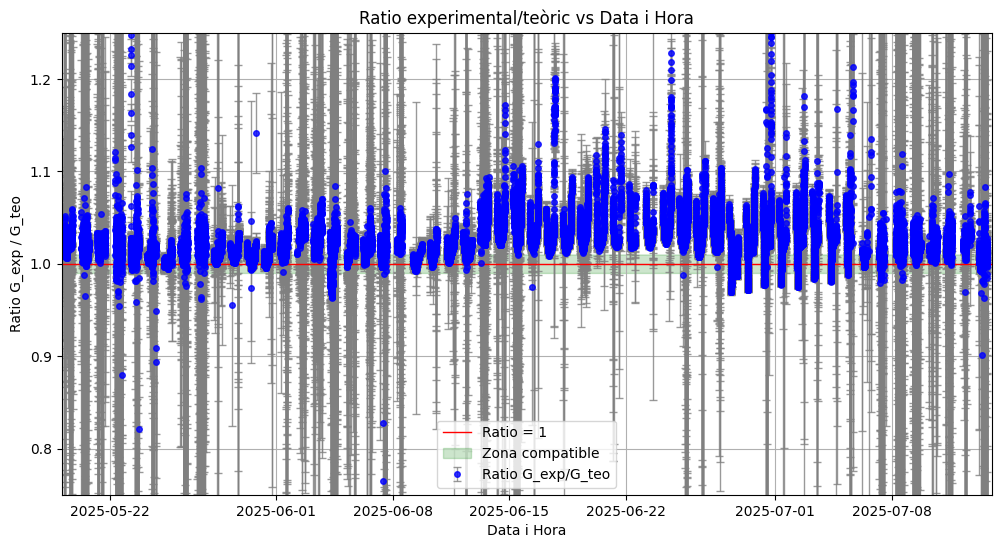

In [6]:
import matplotlib.pyplot as plt
from datetime import datetime

# Un sol dia o fitxer combinat
unSolDia = False

# Converteix data i hora a datetime
datetimes = [datetime.strptime(f'{d} {h}', '%Y-%m-%d %H:%M:%S') for d, h in zip(dates, hores)]

plt.figure(figsize=(12,6))

if unSolDia:
    # Si només és un dia, mostra l'eix X en hores
    # Extraiem les hores en format decimal
    hores_decimals = [int(h.split(':')[0]) + int(h.split(':')[1])/60 + int(h.split(':')[2])/3600 for h in hores]
    plt.errorbar(hores_decimals, ratio_list, yerr=dratio_list, fmt='o', markersize=4, capsize=3, elinewidth=1, label='Ratio G_exp/G_teo', color='blue', ecolor='gray', alpha=0.8)
    plt.axhline(1, color='red', linestyle='-', linewidth=1, label='Ratio = 1')
    plt.fill_between(hores_decimals, [0.99]*len(hores_decimals), [1.01]*len(hores_decimals), color='green', alpha=0.2, label='Zona compatible')
    plt.xlabel('Hora (decimal)')
    plt.xlim(4,21)
else:
    # Fitxer combinat, mostra l'eix X en datetimes
    plt.errorbar(datetimes, ratio_list, yerr=dratio_list, fmt='o', markersize=4, capsize=3, elinewidth=1, label='Ratio G_exp/G_teo', color='blue', ecolor='gray', alpha=0.8)
    plt.axhline(1, color='red', linestyle='-', linewidth=1, label='Ratio = 1')
    plt.fill_between(datetimes, [0.99]*len(datetimes), [1.01]*len(datetimes), color='green', alpha=0.2, label='Zona compatible')
    plt.xlabel('Data i Hora')
    plt.xlim(datetime(2025,5,19,2,0,0), datetime(2025,7,14,0,0,0))

plt.ylabel('Ratio G_exp / G_teo')
plt.title('Ratio experimental/teòric vs Data i Hora' if not unSolDia else 'Ratio experimental/teòric vs Hora')
plt.ylim(0.75, 1.25)
plt.legend()
plt.grid(True)

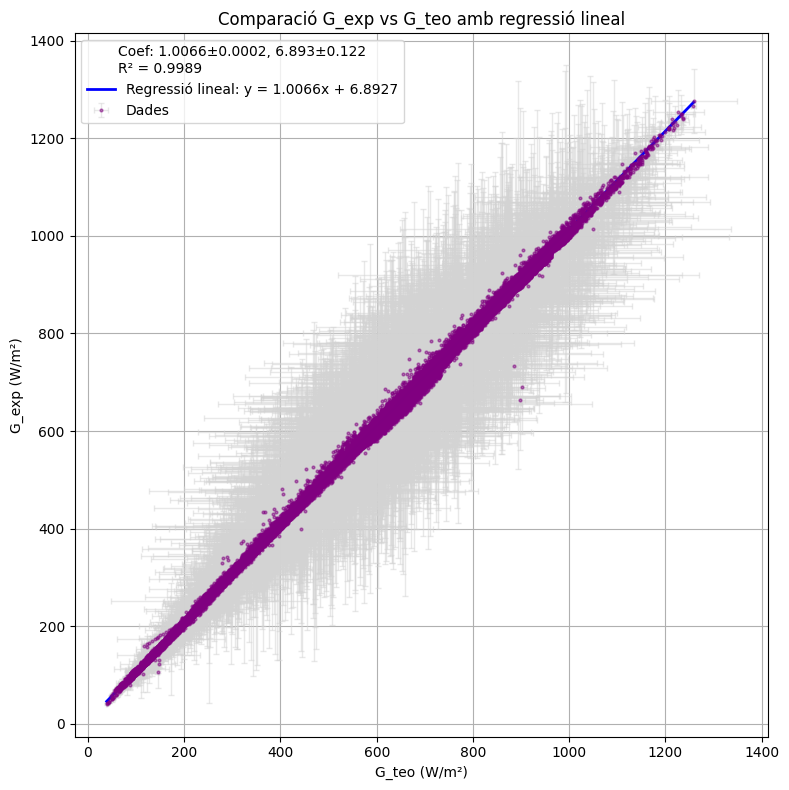

In [7]:
# Grafic g_exp vs G_teo
import numpy as np

plt.figure(figsize=(8,8))
plt.errorbar(G_teo_list, G_exp_list, xerr=dG_teo_list, yerr=dG_exp_list, fmt='o', markersize=2, capsize=2, elinewidth=1, label='Dades', color='purple', ecolor='lightgray', alpha=0.5)

# Regressió lineal amb incertesa i R²
coef, cov = np.polyfit(G_teo_list, G_exp_list, 1, cov=True)
err_coef = np.sqrt(np.diag(cov))  # Incertesa dels coeficients

x_fit = np.linspace(min(G_teo_list), max(G_teo_list), 100)
y_fit = coef[0]*x_fit + coef[1]
plt.plot(x_fit, y_fit, 'b-', linewidth=2, label=f"Regressió lineal: y = {coef[0]:.4f}x + {coef[1]:.4f}")

# Calcula R²
y_pred = coef[0]*np.array(G_teo_list) + coef[1]
ss_res = np.sum((np.array(G_exp_list) - y_pred)**2)
ss_tot = np.sum((np.array(G_exp_list) - np.mean(G_exp_list))**2)
r2 = 1 - ss_res/ss_tot

# Mostra incerteses i R² a la llegenda
plt.legend(title=f"Coef: {coef[0]:.4f}±{err_coef[0]:.4f}, {coef[1]:.3f}±{err_coef[1]:.3f}\nR² = {r2:.4f}")
plt.xlabel('G_teo (W/m²)')
plt.ylabel('G_exp (W/m²)')
plt.title('Comparació G_exp vs G_teo amb regressió lineal')
plt.grid(True)
plt.tight_layout()

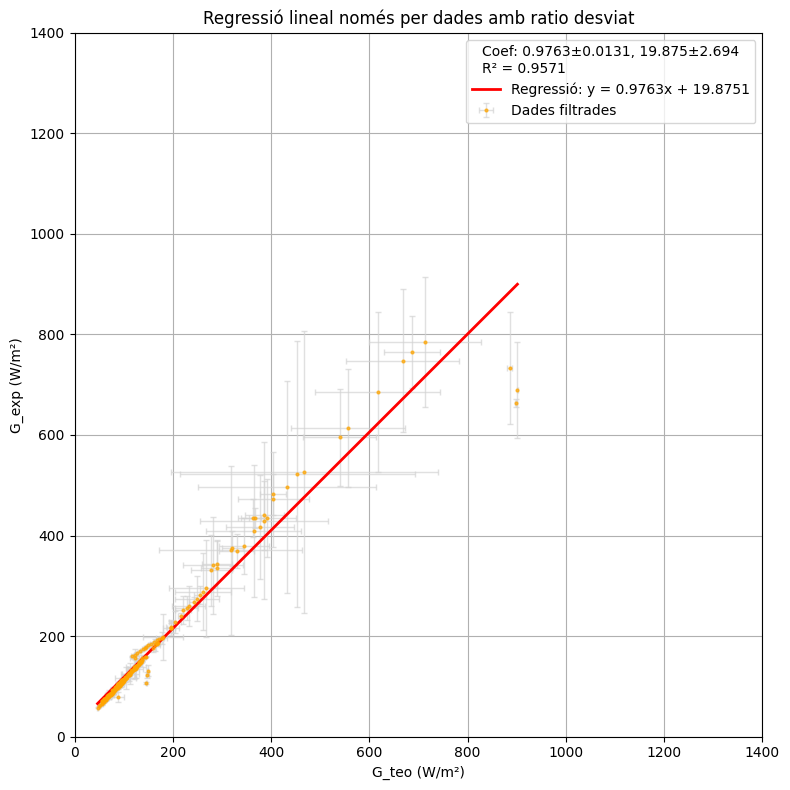

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Filtra les dades que NO compleixen el ratio
idx_no_ratio = [i for i, r in enumerate(ratio_list) if abs(r - 1.0) >= 0.1]
G_teo_no_ratio = [G_teo_list[i] for i in idx_no_ratio]
G_exp_no_ratio = [G_exp_list[i] for i in idx_no_ratio]
dG_teo_no_ratio = [dG_teo_list[i] for i in idx_no_ratio]
dG_exp_no_ratio = [dG_exp_list[i] for i in idx_no_ratio]

plt.figure(figsize=(8,8))
plt.errorbar(G_teo_no_ratio, G_exp_no_ratio, xerr=dG_teo_no_ratio, yerr=dG_exp_no_ratio, fmt='o', markersize=2, capsize=2, elinewidth=1, label='Dades filtrades', color='orange', ecolor='lightgray', alpha=0.7)

# Regressió lineal amb incertesa i R²
if len(G_teo_no_ratio) > 1:
    coef, cov = np.polyfit(G_teo_no_ratio, G_exp_no_ratio, 1, cov=True)
    err_coef = np.sqrt(np.diag(cov))
    x_fit = np.linspace(min(G_teo_no_ratio), max(G_teo_no_ratio), 100)
    y_fit = coef[0]*x_fit + coef[1]
    plt.plot(x_fit, y_fit, 'r-', linewidth=2, label=f"Regressió: y = {coef[0]:.4f}x + {coef[1]:.4f}")
    y_pred = coef[0]*np.array(G_teo_no_ratio) + coef[1]
    ss_res = np.sum((np.array(G_exp_no_ratio) - y_pred)**2)
    ss_tot = np.sum((np.array(G_exp_no_ratio) - np.mean(G_exp_no_ratio))**2)
    r2 = 1 - ss_res/ss_tot
    plt.legend(title=f"Coef: {coef[0]:.4f}±{err_coef[0]:.4f}, {coef[1]:.3f}±{err_coef[1]:.3f}\nR² = {r2:.4f}")
else:
    plt.legend()

plt.xlabel('G_teo (W/m²)')
plt.ylabel('G_exp (W/m²)')
plt.title('Regressió lineal només per dades amb ratio desviat')
plt.grid(True)
plt.xlim(0,1400)
plt.ylim(0,1400)
plt.tight_layout()

In [37]:
import json
import math
from calcularAZS import calcular_cos_AZS

# Llista de fitxers a comparar (pots afegir més fitxers)
input_files = [
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-05-26.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-05-27.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-05-28.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-05-29.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-05-30.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-05-31.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-01.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-03.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-04.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-05.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-06.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-07.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-08.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-09.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-10.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-11.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-12.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-13.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-14.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-15.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-16.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-17.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-18.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-19.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-20.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-21.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-22.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-23.json",
    "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-24.json",
    "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-25.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-26.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-27.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-28.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-29.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-06-30.json",
    "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-07-01.json",
    "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-07-02.json",
    "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-07-03.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-07-04.json",
    # "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-07-05.json",
    "C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/dies/2025-07-06.json",
    # Afegir més fitxers si cal
]

LAT = 41.964
LON = 2.830

# Estructura per guardar les dades de cada dia
dades_per_dia = []

for input_file in input_files:
    with open(input_file, "r") as f:
        dades_json = json.load(f)

    # Inicialitza diccionari per aquest dia
    dia = {
        "dates": [],
        "hores": [],
        "G_teo": [],
        "G_exp": [],
        "dG_teo": [],
        "dG_exp": [],
        "ratio": [],
        "dratio": [],
        "AZS": [],
        "elev": [],
        "PV1": []
    }

    n_filtrats = 0 
    for i, fila in enumerate(dades_json["data"]):

        # if not fila["filtreHoritzo"] or not fila["filtreIrradiancia"]:
        #     continue

        n_filtrats += 1  # Comptem els registres que passen els filtres
        data = fila["DATE"]
        hora = fila["HOUR"]
        B = fila["Beam_Avg"]
        D = fila["Diffuse_Avg"]
        G_exp = fila["Global_Avg"]
        dB = fila["Beam_Std"]
        dD = fila["Diffuse_Std"]
        dG_exp = fila["Global_Std"]
        PV1 = fila["PV1_Avg"]

        cosAZS, dcosAZS = calcular_cos_AZS(LAT, LON, data, hora)
        AZS = math.acos(cosAZS)
        dAZS = dcosAZS / math.sqrt(1 - cosAZS**2)

        G_teo = B * math.cos(AZS) + D
        dG_teo = math.sqrt(
            dD**2 +
            (math.cos(AZS) * dB)**2 +
            (B * math.sin(AZS) * dAZS)**2
        )

        ratio = G_exp / G_teo if G_teo != 0 else float('nan')
        dratio = math.sqrt((dG_exp/G_teo)**2 + (G_exp*dG_teo/G_teo**2)**2) if G_teo != 0 else float('nan')

        # Guarda les dades
        dia["dates"].append(data)
        dia["hores"].append(hora)
        dia["G_teo"].append(G_teo)
        dia["G_exp"].append(G_exp)
        dia["dG_teo"].append(dG_teo)
        dia["dG_exp"].append(dG_exp)
        dia["ratio"].append(ratio)
        dia["dratio"].append(dratio)
        dia["AZS"].append(math.degrees(AZS))
        dia["elev"].append(90 - math.degrees(AZS))
        dia["PV1"].append(PV1)

    print(f"  Registres que passen filtres: {n_filtrats}")
    print(f"  G_teo: {len(dia['G_teo'])}, G_exp: {len(dia['G_exp'])}")

    dades_per_dia.append(dia)

print(f"\nS'han carregat {len(dades_per_dia)} dies.")
for idx, dia in enumerate(dades_per_dia):
    print(f"Dia {idx+1}: {len(dia['G_teo'])} registres útils")

  Registres que passen filtres: 1440
  G_teo: 1440, G_exp: 1440
  Registres que passen filtres: 1440
  G_teo: 1440, G_exp: 1440
  Registres que passen filtres: 1440
  G_teo: 1440, G_exp: 1440
  Registres que passen filtres: 1440
  G_teo: 1440, G_exp: 1440
  Registres que passen filtres: 1440
  G_teo: 1440, G_exp: 1440
  Registres que passen filtres: 1440
  G_teo: 1440, G_exp: 1440

S'han carregat 6 dies.
Dia 1: 1440 registres útils
Dia 2: 1440 registres útils
Dia 3: 1440 registres útils
Dia 4: 1440 registres útils
Dia 5: 1440 registres útils
Dia 6: 1440 registres útils


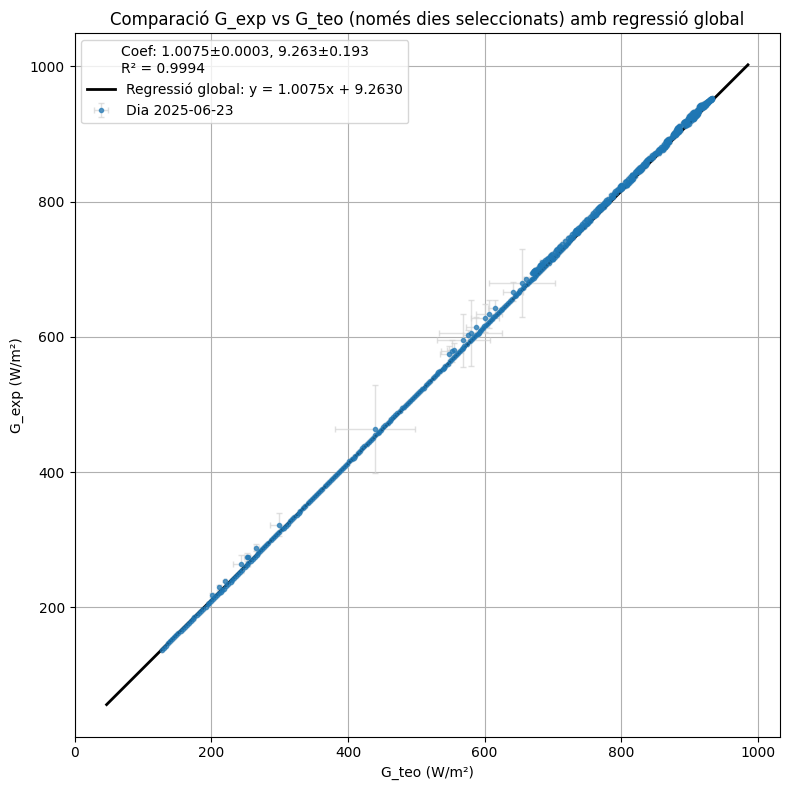

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

dates_to_plot = [
    # "2025-05-27",
    # "2025-05-28",
    # "2025-05-29",
    # "2025-05-30",
    # "2025-05-31",
    # "2025-06-04",
    # "2025-06-05",
    # "2025-06-06",
    # "2025-06-07",

    # "2025-06-15",
    # "2025-06-16",
    # "2025-06-17",
    # "2025-06-18",
    # "2025-06-19",
    # "2025-06-20",
    # "2025-06-21",
    # "2025-06-22",
    # "2025-06-23",
    "2025-06-24",
    

    # "2025-05-26",
    # "2025-06-01",
    # "2025-06-03",
    # "2025-06-22",
    # "2025-07-01",
    # "2025-07-04",
    # "2025-07-05",
]

colors = plt.cm.tab10.colors  # Paleta de colors (fins a 10 dies, després repeteix)

# Filtra només els dies seleccionats per mostrar
dades_filtrades = [dia for dia in dades_per_dia if len(dia["dates"]) > 0 and dia["dates"][0] in dates_to_plot]

for idx, dia in enumerate(dades_filtrades):
    plt.errorbar(
        dia["G_teo"], dia["G_exp"],
        xerr=dia["dG_teo"], yerr=dia["dG_exp"],
        fmt='o', markersize=3, capsize=2, elinewidth=1,
        label=f'Dia {dia["dates"][0]}', color=colors[idx % len(colors)],
        ecolor='lightgray', alpha=0.7
    )

# Regressió lineal global amb totes les dades
G_teo_all = np.concatenate([dia["G_teo"] for dia in dades_per_dia])
G_exp_all = np.concatenate([dia["G_exp"] for dia in dades_per_dia])

if len(G_teo_all) > 1 and len(G_exp_all) > 1:
    coef, cov = np.polyfit(G_teo_all, G_exp_all, 1, cov=True)
    err_coef = np.sqrt(np.diag(cov))

    x_fit = np.linspace(min(G_teo_all), max(G_teo_all), 100)
    y_fit = coef[0]*x_fit + coef[1]
    plt.plot(x_fit, y_fit, 'k-', linewidth=2, label=f"Regressió global: y = {coef[0]:.4f}x + {coef[1]:.4f}")

    # Calcula R² global
    y_pred = coef[0]*G_teo_all + coef[1]
    ss_res = np.sum((G_exp_all - y_pred)**2)
    ss_tot = np.sum((G_exp_all - np.mean(G_exp_all))**2)
    r2 = 1 - ss_res/ss_tot

    plt.legend(title=f"Coef: {coef[0]:.4f}±{err_coef[0]:.4f}, {coef[1]:.3f}±{err_coef[1]:.3f}\nR² = {r2:.4f}")
else:
    plt.legend()
    print("No hi ha dades suficients per fer la regressió global.")

plt.xlabel('G_teo (W/m²)')
plt.ylabel('G_exp (W/m²)')
plt.title('Comparació G_exp vs G_teo (només dies seleccionats) amb regressió global')
plt.grid(True)
plt.tight_layout()

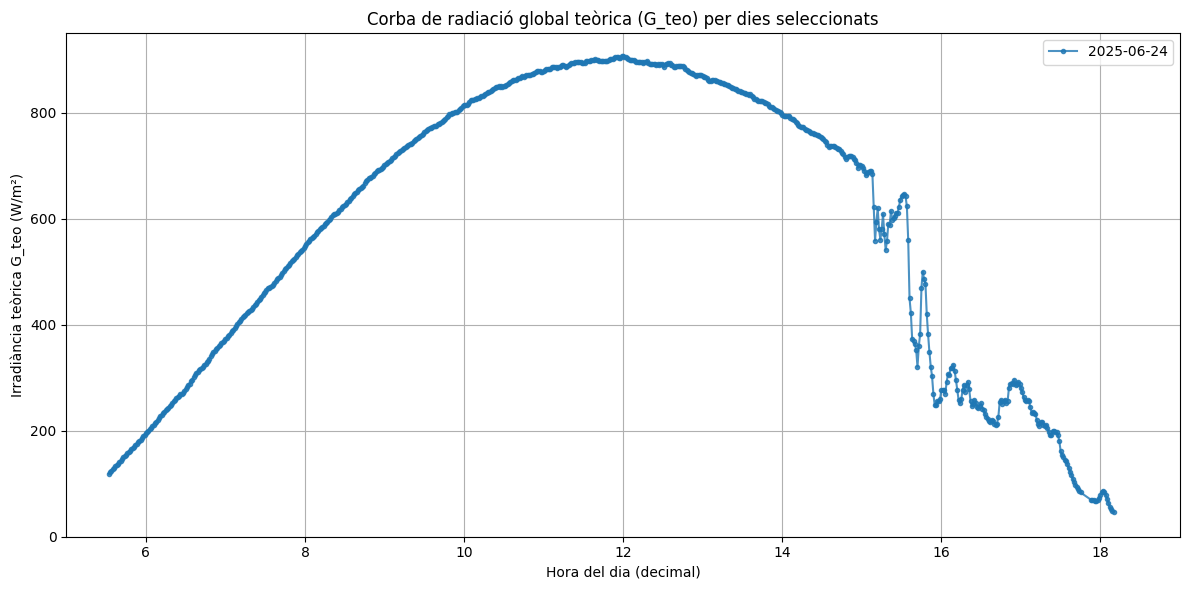

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

graficarExp = False # False si es vol graficar la teorica

dates_to_plot = [
    "2025-06-24",
]

# 1 Normal (tots els punts) | 2 (Sols els que compleixen el ratio) | 3 (Sols els que no compleixen el ratio)
ratioOpcio = 1
ratioLimit = 0.05

colors = plt.cm.tab10.colors

# Filtra només els dies seleccionats
dades_filtrades = [dia for dia in dades_per_dia if len(dia["dates"]) > 0 and dia["dates"][0] in dates_to_plot]

for idx, dia in enumerate(dades_filtrades):
    hores_decimals = []
    G_filtrat = []
    G_list = dia["G_exp"] if graficarExp else dia["G_teo"]

    for h, r, g in zip(dia["hores"], dia["ratio"], G_list):
        hora_decimal = int(h.split(':')[0]) + int(h.split(':')[1])/60 + int(h.split(':')[2])/3600
        if ratioOpcio == 1:
            hores_decimals.append(hora_decimal)
            G_filtrat.append(g)
        elif ratioOpcio == 2 and abs(r - 1.0) < ratioLimit:
            hores_decimals.append(hora_decimal)
            G_filtrat.append(g)
        elif ratioOpcio == 3 and abs(r - 1.0) >= ratioLimit:
            hores_decimals.append(hora_decimal)
            G_filtrat.append(g)
    plt.plot(
        hores_decimals, G_filtrat,
        'o-', markersize=3, label=dia["dates"][0], color=colors[idx % len(colors)], alpha=0.8
    )

title = (f"{ratioLimit} Off Ratio - " if ratioOpcio == 3 else '') + 'Corba de radiació global' + (' experimental (G_exp)' if graficarExp else ' teòrica (G_teo)') + ' per dies seleccionats'
ylabel = 'Irradiància' + (' experimental G_exp' if graficarExp else ' teòrica G_teo') + ' (W/m²)'
plt.xlabel('Hora del dia (decimal)')
plt.ylabel(ylabel)
plt.title(title)
plt.xlim(5, 19)
# plt.xlim(10,14)
plt.ylim(bottom=0)
# plt.ylim(800,1000)
plt.legend()
plt.grid(True)
plt.tight_layout()

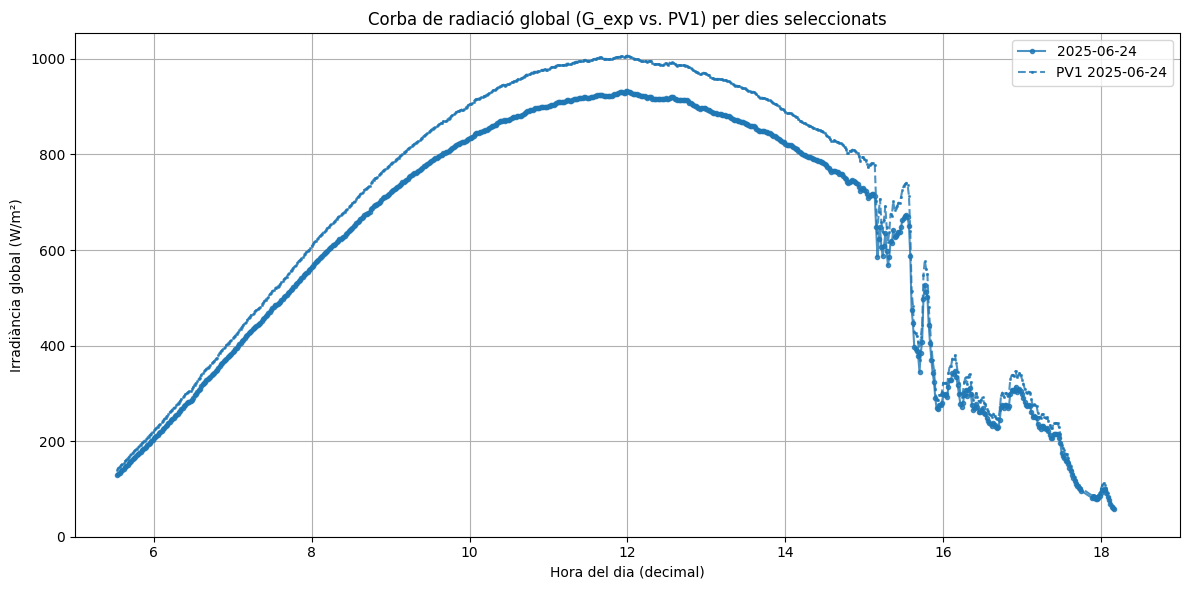

In [14]:
# I ara irradiànica PV1 al llarg del dia comparada amb G_exp o amb G_teo 

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

graficarExp = True # False si es vol graficar la teorica

dates_to_plot = [
    # "2025-05-29",
    # "2025-05-30",
    # "2025-06-16",
    # "2025-06-17",
    # "2025-06-18",
    # "2025-06-19",
    # "2025-06-20",
    # "2025-06-21",
    # "2025-06-22",
    # "2025-06-23",
    "2025-06-24",
]

# 1 Normal (tots els punts) | 2 (Sols els que compleixen el ratio) | 3 (Sols els que no compleixen el ratio)
ratioOpcio = 1
ratioLimit = 0.05

colors = plt.cm.tab10.colors

# Filtra només els dies seleccionats
dades_filtrades = [dia for dia in dades_per_dia if len(dia["dates"]) > 0 and dia["dates"][0] in dates_to_plot]

for idx, dia in enumerate(dades_filtrades):
    hores_decimals = []
    G_filtrat = []
    PV1_filtrat = []
    G_list = dia["G_exp"] if graficarExp else dia["G_teo"]

    for h, r, g, pv1 in zip(dia["hores"], dia["ratio"], G_list, dia["PV1"]):
        hora_decimal = int(h.split(':')[0]) + int(h.split(':')[1])/60 + int(h.split(':')[2])/3600
        if ratioOpcio == 1:
            hores_decimals.append(hora_decimal)
            G_filtrat.append(g)
            PV1_filtrat.append(pv1)
        elif ratioOpcio == 2 and abs(r - 1.0) < ratioLimit:
            hores_decimals.append(hora_decimal)
            G_filtrat.append(g)
            PV1_filtrat.append(pv1)
        elif ratioOpcio == 3 and abs(r - 1.0) >= ratioLimit:
            hores_decimals.append(hora_decimal)
            G_filtrat.append(g)
            PV1_filtrat.append(pv1)
    plt.plot(
        hores_decimals, G_filtrat,
        'o-', markersize=3, label=dia["dates"][0], color=colors[idx % len(colors)], alpha=0.8
    )
    plt.plot(
        hores_decimals, PV1_filtrat,
        's--', markersize=1, label=f'PV1 {dia["dates"][0]}', color=colors[idx % len(colors)], alpha=0.8
    )

title = (f"{ratioLimit} Off Ratio - " if ratioOpcio == 3 else '') + 'Corba de radiació global' + (' (G_exp' if graficarExp else ' (G_teo') + ' vs. PV1) per dies seleccionats'
ylabel = 'Irradiància global (W/m²)'
plt.xlabel('Hora del dia (decimal)')
plt.ylabel(ylabel)
plt.title(title)
plt.xlim(5, 19)
# plt.xlim(10,14)
plt.ylim(bottom=0)
# plt.ylim(800,1000)
plt.legend()
plt.grid(True)
plt.tight_layout()

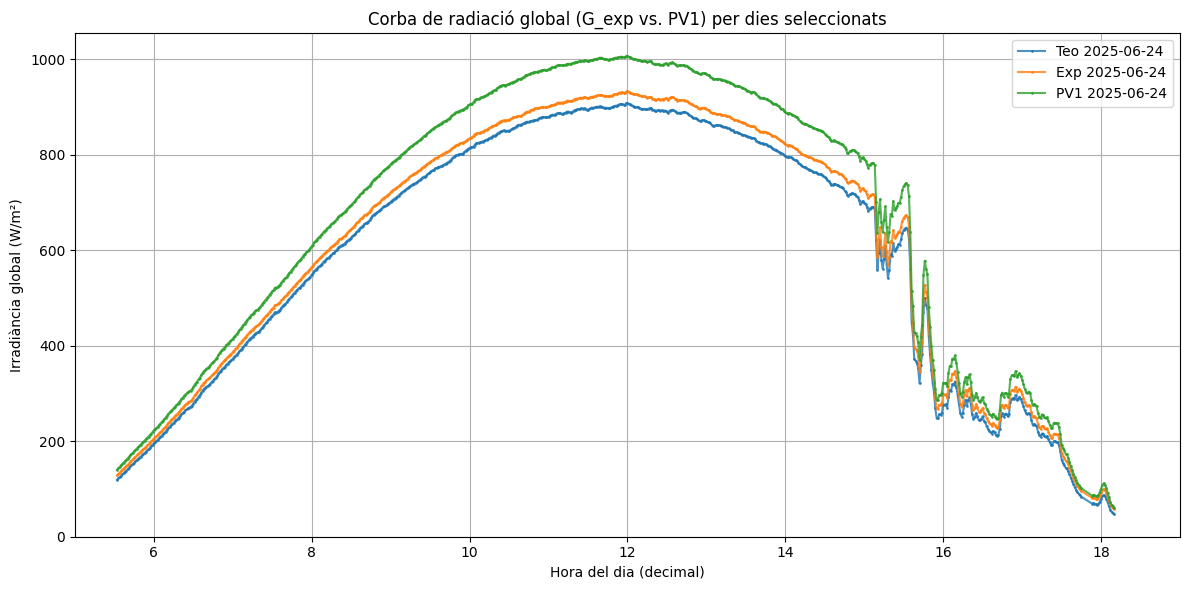

In [ ]:
# I ara irradiànica PV1 al llarg del dia comparada amb G_exp i amb G_teo 

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

dates_to_plot = [
    "2025-06-24",
]

# 1 Normal (tots els punts) | 2 (Sols els que compleixen el ratio) | 3 (Sols els que no compleixen el ratio)
ratioOpcio = 1
ratioLimit = 0.05

colors = plt.cm.tab10.colors

# Filtra només els dies seleccionats
dades_filtrades = [dia for dia in dades_per_dia if len(dia["dates"]) > 0 and dia["dates"][0] in dates_to_plot]

for idx, dia in enumerate(dades_filtrades):
    hores_decimals = []
    G_teo_filtrat = []
    G_exp_filtrat = []
    PV1_filtrat = []
    G_teo_list = dia["G_teo"]
    G_exp_list = dia["G_exp"]

    for h, r, g_t, g_e, pv1 in zip(dia["hores"], dia["ratio"], G_teo_list, G_exp_list, dia["PV1"]):
        hora_decimal = int(h.split(':')[0]) + int(h.split(':')[1])/60 + int(h.split(':')[2])/3600
        if ratioOpcio == 1:
            hores_decimals.append(hora_decimal)
            G_teo_filtrat.append(g_t)
            G_exp_filtrat.append(g_e)
            PV1_filtrat.append(pv1)
        elif ratioOpcio == 2 and abs(r - 1.0) < ratioLimit:
            hores_decimals.append(hora_decimal)
            G_teo_filtrat.append(g_t)
            G_exp_filtrat.append(g_e)
            PV1_filtrat.append(pv1)
        elif ratioOpcio == 3 and abs(r - 1.0) >= ratioLimit:
            hores_decimals.append(hora_decimal)
            G_teo_filtrat.append(g_t)
            G_exp_filtrat.append(g_e)
            PV1_filtrat.append(pv1)
    plt.plot(
        hores_decimals, G_teo_filtrat,
        'o-', markersize=1, label=f'Teo {dia["dates"][0]}', color=colors[idx % len(colors)], alpha=0.8
    )
    plt.plot(
        hores_decimals, G_exp_filtrat,
        'o-', markersize=1, label=f'Exp {dia["dates"][0]}', color=colors[idx % len(colors)+1], alpha=0.8
    )
    plt.plot(
        hores_decimals, PV1_filtrat,
        'o-', markersize=1, label=f'PV1 {dia["dates"][0]}', color=colors[idx % len(colors)+2], alpha=0.8
    )

title = (f"{ratioLimit} Off Ratio - " if ratioOpcio == 3 else '') + 'Corba de radiació global' + (' (G_exp' if graficarExp else ' (G_teo') + ' vs. PV1) per dies seleccionats'
ylabel = 'Irradiància global (W/m²)'
plt.xlabel('Hora del dia (decimal)')
plt.ylabel(ylabel)
plt.title(title)
plt.xlim(5, 19)
# plt.xlim(10,14)
plt.ylim(bottom=0)
# plt.ylim(800,1000)
plt.legend()
plt.grid(True)
plt.tight_layout()

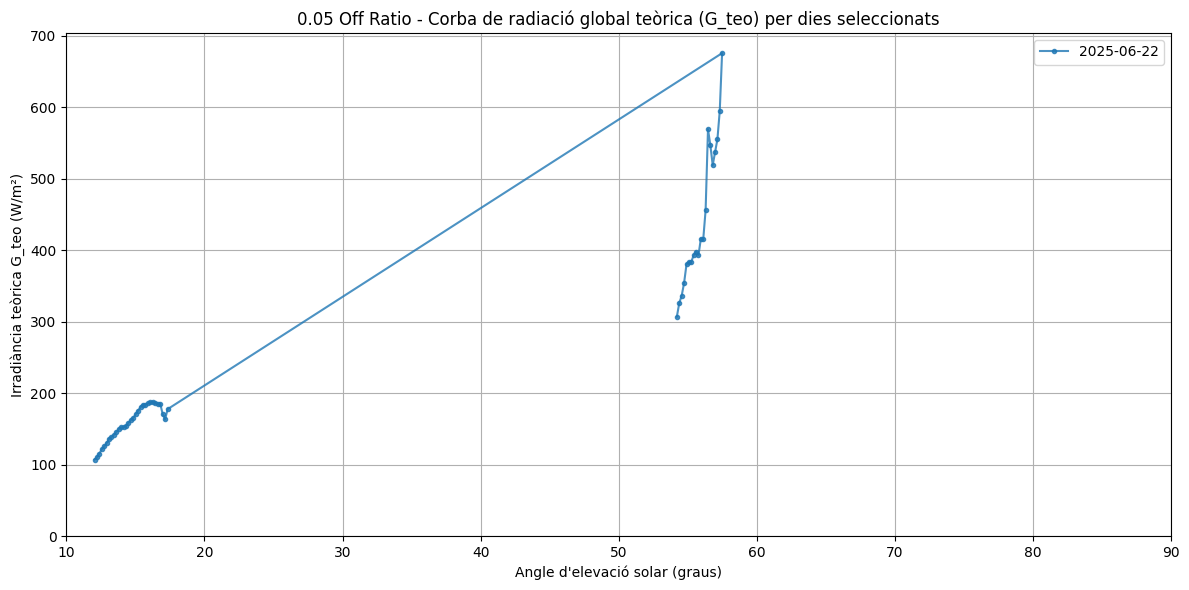

In [43]:
# Ara el mateix però amb angle d'elevació solar enlloc de hores del dia

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

dates_to_plot = [
    "2025-05-26",
    "2025-06-01",
    "2025-06-03",
    "2025-06-22",
    "2025-07-01",
    "2025-07-04",
    "2025-07-05",
]

graficarExp = False # False si es vol graficar la teorica

# 1 Normal (tots els punts) | 2 (Sols els que compleixen el ratio) | 3 (Sols els que no compleixen el ratio)
ratioOpcio = 3
ratioLimit = 0.05

colors = plt.cm.tab10.colors

# Filtra només els dies seleccionats
dades_filtrades = [dia for dia in dades_per_dia if len(dia["dates"]) > 0 and dia["dates"][0] in dates_to_plot]

for idx, dia in enumerate(dades_filtrades):
    elev_filtrat = []
    G_filtrat = []
    G_list = dia["G_exp"] if graficarExp else dia["G_teo"]

    for elev, r, g in zip(dia["elev"], dia["ratio"], dia["G_teo"]):
        if ratioOpcio == 1:
            elev_filtrat.append(elev)
            G_filtrat.append(g)
        elif ratioOpcio == 2 and abs(r - 1.0) < ratioLimit:
            elev_filtrat.append(elev)
            G_filtrat.append(g)
        elif ratioOpcio == 3 and abs(r - 1.0) >= ratioLimit:
            elev_filtrat.append(elev)
            G_filtrat.append(g)
    plt.plot(
        elev_filtrat, G_filtrat,
        'o-', markersize=3, label=dia["dates"][0], color=colors[idx % len(colors)], alpha=0.8
    )

title = (f"{ratioLimit} Off Ratio - " if ratioOpcio == 3 else '') + 'Corba de radiació global' + (' experimental (G_exp)' if graficarExp else ' teòrica (G_teo)') + ' per dies seleccionats'
ylabel = 'Irradiància' + (' experimental G_exp' if graficarExp else ' teòrica G_teo') + ' (W/m²)'
plt.xlabel("Angle d'elevació solar (graus)")
plt.ylabel(ylabel)
plt.title(title)
plt.xlim(10, 90)
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()

In [ ]:
# Ara ho compararem amb les dades de l'Processar_ICAEN
# Primer calculem la mitjana i la desviació estàndard de les dades de l'ICAEN

import json
import numpy as np

dataIcaen = "2025-06-24"

# Nom del fitxer JSON
input_icaen_file = f"C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/diesIcaen/ICAEN_{dataIcaen}.json"

# Carreguem el fitxer JSON
with open(input_icaen_file, "r") as f:
    dades = json.load(f)

# Inicialitzem llistes
dates = []
hores = []
PYR1 = []
PYR2 = []
PYR3 = []
PYR4 = []
PYR5 = []
PYR6 = []
PYR_Avg = []
PYR_Std = []

print(f"Nombre de objectes de dades al fitxer: {len(dades['data'])}")

max_files = min(120000, len(dades["data"])-1)

# Per cada mesura, calcularem un promig i la corresponent incertesa estadística
for i, fila in enumerate(dades["data"]):
    if i > max_files:
        break

    data = fila["DATE"]
    hora = fila["HOUR"]
    P1 = fila["PYR1"]
    P2 = fila["PYR2"]
    P3 = fila["PYR3"]
    P4 = fila["PYR4"]
    P5 = fila["PYR5"]
    P6 = fila["PYR6"]

    PYR_values = [P1, P2, P3, P4, P5, P6]

    # Mitjana
    P_Avg = np.mean(PYR_values)

    # Incertesa
    P_Std = np.std(PYR_values, ddof=1) / np.sqrt(6)

    # Guardem els valors a les llistes
    dates.append(data)
    hores.append(hora)
    PYR1.append(P1)
    PYR2.append(P2)
    PYR3.append(P3)
    PYR4.append(P4)
    PYR5.append(P5)
    PYR6.append(P6)
    PYR_Avg.append(P_Avg)
    PYR_Std.append(P_Std)

    if i % 100 == 0:
        print(f"Registre {i+1}/{max_files}: {data} {hora} | P_Avg: {P_Avg:.2f} ; P_Std: {P_Std:.2f}")

print(f"Ja hem acabat. Registres processats: {len(dates)}")

Nombre de objectes de dades al fitxer: 1440
Registre 1/1439: 2025-06-24 00:00:00 | P_Avg: -0.01 ; P_Std: 0.00
Registre 101/1439: 2025-06-24 01:40:00 | P_Avg: -0.01 ; P_Std: 0.00
Registre 201/1439: 2025-06-24 03:20:00 | P_Avg: -0.01 ; P_Std: 0.00
Registre 301/1439: 2025-06-24 05:00:00 | P_Avg: 0.33 ; P_Std: 0.04
Registre 401/1439: 2025-06-24 06:40:00 | P_Avg: 2.16 ; P_Std: 0.34
Registre 501/1439: 2025-06-24 08:20:00 | P_Avg: 4.16 ; P_Std: 0.66
Registre 601/1439: 2025-06-24 10:00:00 | P_Avg: 5.63 ; P_Std: 0.88
Registre 701/1439: 2025-06-24 11:40:00 | P_Avg: 6.24 ; P_Std: 0.96
Registre 801/1439: 2025-06-24 13:20:00 | P_Avg: 5.92 ; P_Std: 0.91
Registre 901/1439: 2025-06-24 15:00:00 | P_Avg: 4.87 ; P_Std: 0.74
Registre 1001/1439: 2025-06-24 16:40:00 | P_Avg: 1.52 ; P_Std: 0.23
Registre 1101/1439: 2025-06-24 18:20:00 | P_Avg: 0.23 ; P_Std: 0.04
Registre 1201/1439: 2025-06-24 20:00:00 | P_Avg: -0.02 ; P_Std: 0.00
Registre 1301/1439: 2025-06-24 21:40:00 | P_Avg: -0.02 ; P_Std: 0.00
Registre 14

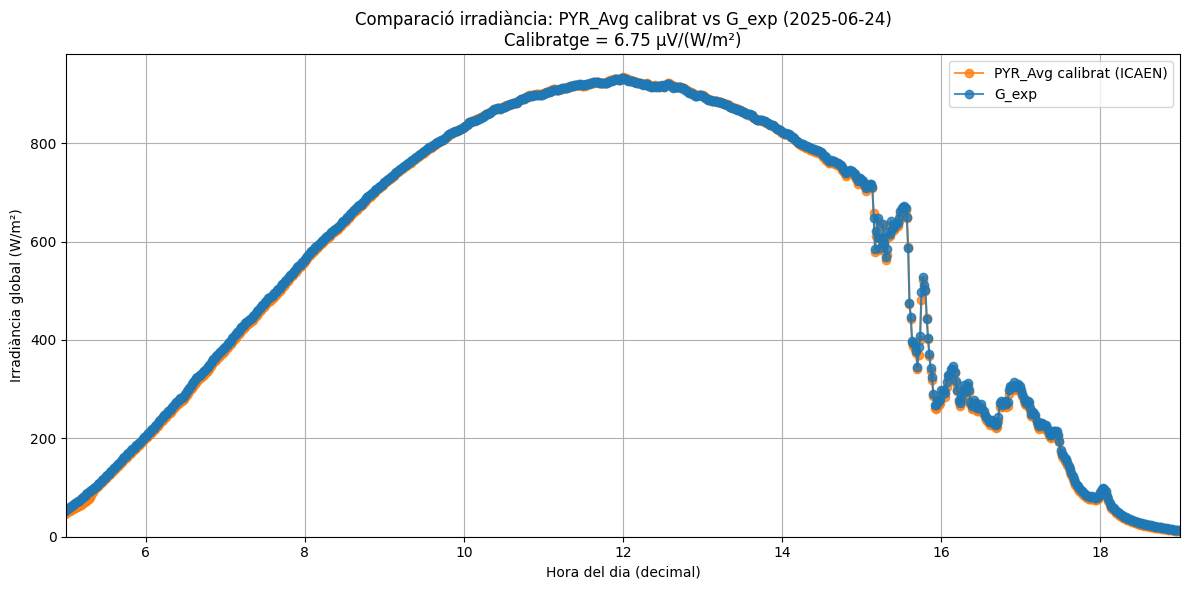

In [28]:
# Gràfic comparatiu: PYR_Avg calibrat vs G_exp o G_teo per al dia 2025-06-24

import numpy as np
import matplotlib.pyplot as plt

# Factor de calibratge (μV/(W/m²))
calibratge = 6.75

# Converteix PYR_Avg (mV) a irradiància (W/m²)
irradiancia_pyr = np.array(PYR_Avg) * 1000 / calibratge

# Calcula hores decimals per a les dades ICAEN (PYR_Avg)
hores_decimals_pyr = [int(h.split(':')[0]) + int(h.split(':')[1])/60 + int(h.split(':')[2])/3600 for h in hores]

# Troba el dia a dades_per_dia
diaAnalitzat = "2025-06-24"
# Si tens només un dia, pots fer:

# Però millor busca'l per data:
dia_ = next(d for d in dades_per_dia if len(d["dates"]) > 0 and d["dates"][0] == diaAnalitzat)

# Calcula hores decimals per a les dades pròpies
hores_decimals_own = [int(h.split(':')[0]) + int(h.split(':')[1])/60 + int(h.split(':')[2])/3600 for h in dia["hores"]]

# Selecciona si vols comparar amb G_exp o G_teo
vsExp = True  # True per comparar amb G_exp, False amb G_teo
G_llista = dia["G_exp"] if vsExp else dia["G_teo"]

plt.figure(figsize=(12,6))
plt.plot(hores_decimals_pyr, irradiancia_pyr, 'o-', label='PYR_Avg calibrat (ICAEN)', color='tab:orange', alpha=0.8)
plt.plot(hores_decimals_own, G_llista, 'o-', label='G_exp' if vsExp else 'G_teo', color='tab:blue', alpha=0.8)

plt.xlabel('Hora del dia (decimal)')
plt.ylabel('Irradiància global (W/m²)')
plt.title(f'Comparació irradiància: PYR_Avg calibrat vs {"G_exp" if vsExp else "G_teo"} ({diaAnalitzat})\nCalibratge = {calibratge} μV/(W/m²)')
plt.xlim(5, 19)
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()

Dimensions llistes: 1440 ; 1440


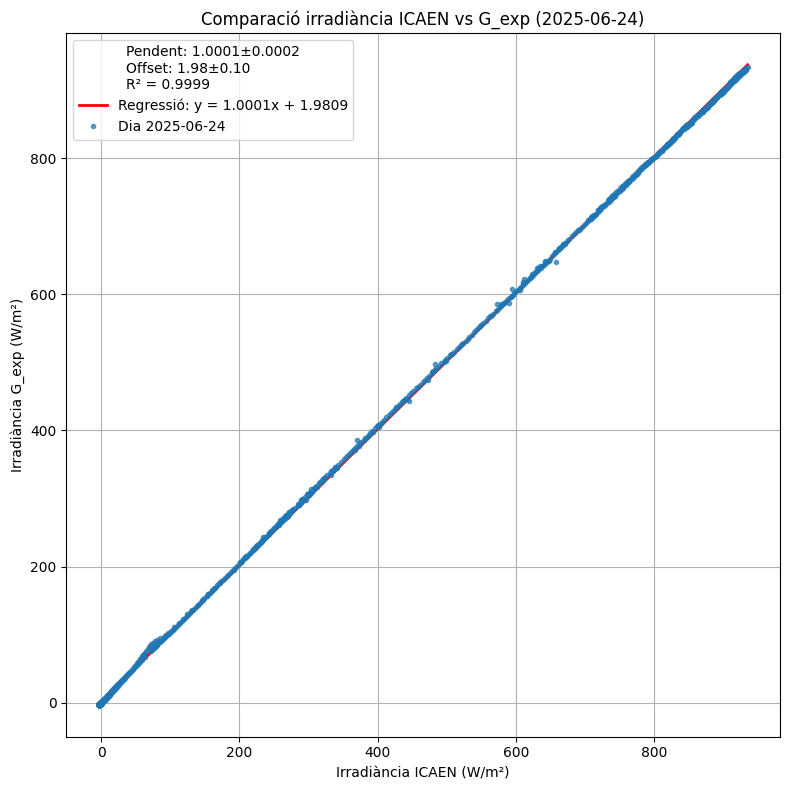

In [30]:
# Ara anem a graficar G_exp (o G_teo) vs PYRH irradiancia_pyr fent una regressio lineal 
# L'objectiu serà anar ajustant calibratge per tal que el pendent sigui molt proper a 1

import numpy as np
import matplotlib.pyplot as plt

# Factor de calibratge (μV/(W/m²))
calibratge = 6.75

# Converteim PYR_Avg (mV) a irradiància (W/m²)
irradiancia_pyr = np.array(PYR_Avg) * 1000 / calibratge

vsExp = True  # True per comparar amb G_exp, False amb G_teo
diaAnalitzat = "2025-06-24"
dia = next(d for d in dades_per_dia if len(d["dates"]) > 0 and d["dates"][0] == diaAnalitzat)
G_llista = np.array(dia["G_exp"]) if vsExp else np.array(dia["G_teo"])


print(f"Dimensions llistes: {len(irradiancia_pyr)} ; {len(G_llista)}")

plt.figure(figsize=(8,8))
plt.errorbar(irradiancia_pyr, G_llista, fmt='o', markersize=3, capsize=2, elinewidth=1,
             label=f'Dia {diaAnalitzat}', color='tab:blue', ecolor='lightgray', alpha=0.7)

# Regressió lineal
if len(irradiancia_pyr) > 1 and len(G_llista) > 1:
    coef, cov = np.polyfit(irradiancia_pyr, G_llista, 1, cov=True)
    err_coef = np.sqrt(np.diag(cov))

    x_fit = np.linspace(min(irradiancia_pyr), max(irradiancia_pyr), 100)
    y_fit = coef[0]*x_fit + coef[1]
    plt.plot(x_fit, y_fit, 'r-', linewidth=2, label=f"Regressió: y = {coef[0]:.4f}x + {coef[1]:.4f}")

    # Calcula R²
    y_pred = coef[0]*irradiancia_pyr + coef[1]
    ss_res = np.sum((G_llista - y_pred)**2)
    ss_tot = np.sum((G_llista - np.mean(G_llista))**2)
    r2 = 1 - ss_res/ss_tot

    plt.legend(title=f"Pendent: {coef[0]:.4f}±{err_coef[0]:.4f}\nOffset: {coef[1]:.2f}±{err_coef[1]:.2f}\nR² = {r2:.4f}")
else:
    plt.legend()
    print("No hi ha dades suficients per fer la regressió.")

plt.xlabel('Irradiància ICAEN (W/m²)')
plt.ylabel(f'Irradiància {"G_exp" if vsExp else "G_teo"} (W/m²)')
plt.title(f'Comparació irradiància ICAEN vs {"G_exp" if vsExp else "G_teo"} ({diaAnalitzat})')
plt.grid(True)
plt.tight_layout()

In [34]:
# Ara apliquem la regressió a altres dies per veure si el calibratge és consistent

import json
import numpy as np

dies_icaen_str = [
    "2025-06-24",
    "2025-06-25",
    "2025-07-01",
    "2025-07-02",
    "2025-07-03",
    "2025-07-06",
]

dies_icaen = []

for diaTriatIcaen in dies_icaen_str:
    input_icaen_file = f"C:/Users/PC/Documents/_PRACTIQUES_UDG/scripts/diesIcaen/ICAEN_{diaTriatIcaen}.json"
    with open(input_icaen_file, "r") as f:
        dades = json.load(f)

    dates = []
    hores = []
    PYR_Avg = []
    PYR_Std = []

    max_files = min(120000, len(dades["data"])-1)

    for i, fila in enumerate(dades["data"]):
        if i > max_files:
            break

        data = fila["DATE"]
        hora = fila["HOUR"]
        PYR_values = [fila["PYR1"], fila["PYR2"], fila["PYR3"], fila["PYR4"], fila["PYR5"], fila["PYR6"]]
        P_Avg = np.mean(PYR_values)
        P_Std = np.std(PYR_values, ddof=1) / np.sqrt(6)

        dates.append(data)
        hores.append(hora)
        PYR_Avg.append(P_Avg)
        PYR_Std.append(P_Std)

    dies_icaen.append({
        "dia": diaTriatIcaen,
        "dates": dates,
        "hores": hores,
        "PYR_Avg": PYR_Avg,
        "PYR_Std": PYR_Std
    })

print(f"S'han carregat {len(dies_icaen)} dies ICAEN.")
for d in dies_icaen:
    print(f"Dia {d['dia']}: {len(d['PYR_Avg'])} registres")

S'han carregat 6 dies ICAEN.
Dia 2025-06-24: 1440 registres
Dia 2025-06-25: 1440 registres
Dia 2025-07-01: 1440 registres
Dia 2025-07-02: 1440 registres
Dia 2025-07-03: 1440 registres
Dia 2025-07-06: 1440 registres


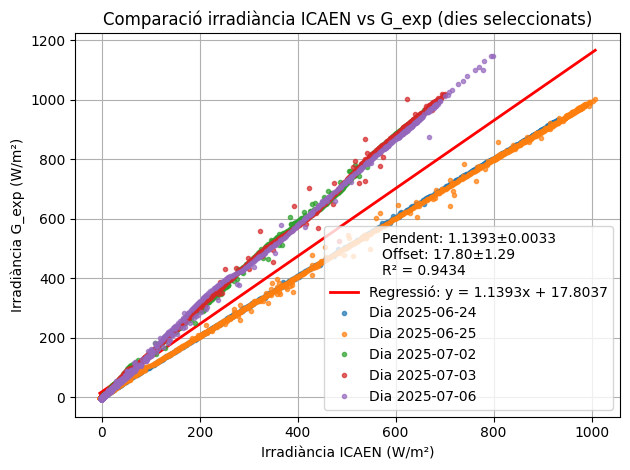

In [48]:
# Ara anem a graficar la recta amb els dies seleccionats

import numpy as np
import matplotlib.pyplot as plt

calibratge = 6.75  # μV/(W/m²)
vsExp = True  # True per comparar amb G_exp, False amb G_teo

diesSeleccionats = [
    "2025-06-24",
    "2025-06-25",
    "2025-07-02",
    "2025-07-03",
    "2025-07-06",
]

# Recull les dades dels dies seleccionats
irradiancia_pyr_all = []
G_llista_all = []

for dia_str in diesSeleccionats:
    # Troba el dia ICAEN
    dia_icaen = next((d for d in dies_icaen if d["dia"] == dia_str), None)
    # Troba el dia de dades globals
    dia_global = next((d for d in dades_per_dia if len(d["dates"]) > 0 and d["dates"][0] == dia_str), None)
    if dia_icaen is None or dia_global is None:
        print(f"Dia {dia_str} no trobat a dies_icaen o dades_per_dia.")
        continue

    # Calibra la irradiància ICAEN
    irradiancia_pyr = np.array(dia_icaen["PYR_Avg"]) * 1000 / calibratge
    G_llista = np.array(dia_global["G_exp"]) if vsExp else np.array(dia_global["G_teo"])

    # Mostra punts
    plt.errorbar(irradiancia_pyr, G_llista, fmt='o', markersize=3, capsize=2, elinewidth=1,
                 label=f'Dia {dia_str}', alpha=0.7)

    irradiancia_pyr_all.append(irradiancia_pyr)
    G_llista_all.append(G_llista)

# Concatenem totes les dades seleccionades
irradiancia_pyr_all = np.concatenate(irradiancia_pyr_all)
G_llista_all = np.concatenate(G_llista_all)

# Regressió lineal només amb els dies seleccionats
if len(irradiancia_pyr_all) > 1 and len(G_llista_all) > 1:
    coef, cov = np.polyfit(irradiancia_pyr_all, G_llista_all, 1, cov=True)
    err_coef = np.sqrt(np.diag(cov))

    x_fit = np.linspace(min(irradiancia_pyr_all), max(irradiancia_pyr_all), 100)
    y_fit = coef[0]*x_fit + coef[1]
    plt.plot(x_fit, y_fit, 'r-', linewidth=2, label=f"Regressió: y = {coef[0]:.4f}x + {coef[1]:.4f}")

    # Calcula R²
    y_pred = coef[0]*irradiancia_pyr_all + coef[1]
    ss_res = np.sum((G_llista_all - y_pred)**2)
    ss_tot = np.sum((G_llista_all - np.mean(G_llista_all))**2)
    r2 = 1 - ss_res/ss_tot

    plt.legend(title=f"Pendent: {coef[0]:.4f}±{err_coef[0]:.4f}\nOffset: {coef[1]:.2f}±{err_coef[1]:.2f}\nR² = {r2:.4f}")
else:
    plt.legend()
    print("No hi ha dades suficients per fer la regressió.")

plt.xlabel('Irradiància ICAEN (W/m²)')
plt.ylabel(f'Irradiància {"G_exp" if vsExp else "G_teo"} (W/m²)')
plt.title(f'Comparació irradiància ICAEN vs {"G_exp" if vsExp else "G_teo"} (dies seleccionats)')
plt.grid(True)
plt.tight_layout()